In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lightgbm as lgb
import xgboost as xgb

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union

In [5]:
from tpot.builtins import StackingEstimator

In [6]:
filename = "uklon_sample_3_months_dropnan_driver_id.csv"

In [7]:
parse_dates = ['created_at']

In [8]:
df = pd.read_csv(filename, delimiter=",", parse_dates=parse_dates)

/home/temenid/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.head()

,order_id,ride_id,created_at,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,user_id,driver_id,ride_distance,...,ooExtraCost,ooInitialCost,ooIdleCost,oapAzureMlCost,oapAzureMlCostBid,oapCostProvider,ooSurgeMultiplier,driver_lat,driver_lon,dtTaxiDriver_tdID
0,88314768,764A34A6-5C92-4A0C-90E8-82BDA5A5F9C1,2017-10-31 23:59:59.143,50.448906,30.386448,50.410267,30.412216,420361.0,568114.0,9.10,...,1.0,115.0,0.0,114.0,1.0,AzureML,1.35,50.437012,30.383680,568114.0
1,88314766,299E8328-8BE6-4097-AF81-4834478B4D51,2017-10-31 23:59:58.577,50.446000,30.576200,50.414604,30.384350,722883.0,553135.0,19.74,...,0.0,146.0,0.0,146.0,0.0,AzureML,1.00,50.449512,30.595537,553135.0
2,88314763,4EDC7FB9-5E34-4132-A2B3-B926F81DB439,2017-10-31 23:59:55.050,50.438610,30.459536,50.439339,30.444427,693323.0,568920.0,11.08,...,-7.0,100.0,0.0,107.0,1.0,AzureML,1.09,50.424972,30.458965,568920.0
3,88314762,D0EE9C9A-CFDD-44F8-906D-7C3A7ED65A1C,2017-10-31 23:59:54.420,50.449707,30.515345,50.459896,30.402002,17563.0,527239.0,9.24,...,0.0,88.0,0.0,88.0,0.0,NaN,1.00,50.455327,30.515555,527239.0
4,88314759,18B41EC0-B379-4621-BF7A-DD881D16E038,2017-10-31 23:59:50.053,50.397000,30.632500,50.416607,30.633417,754011.0,531709.0,3.73,...,0.0,55.0,0.0,NaN,NaN,NaN,1.01,NaN,NaN,NaN


In [10]:
df.columns

Index(['order_id', 'ride_id', 'created_at', 'pickup_lat', 'pickup_lon',
       'dropoff_lat', 'dropoff_lon', 'user_id', 'driver_id', 'ride_distance',
       'ooCancelReason', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost',
       'ooExtraCost', 'ooInitialCost', 'ooIdleCost', 'oapAzureMlCost',
       'oapAzureMlCostBid', 'oapCostProvider', 'ooSurgeMultiplier',
       'driver_lat', 'driver_lon', 'dtTaxiDriver_tdID'],
      dtype='object')

In [11]:
df.isnull().sum()

order_id                    0
ride_id                     0
created_at                  0
pickup_lat                565
pickup_lon                565
dropoff_lat               780
dropoff_lon               780
user_id                378190
driver_id                   0
ride_distance               0
ooCancelReason              0
ooSuburbanDistance          0
ooCarSearchTime             0
ooCost                      0
ooExtraCost                 0
ooInitialCost               0
ooIdleCost                  0
oapAzureMlCost        1521212
oapAzureMlCostBid     1521212
oapCostProvider       1350984
ooSurgeMultiplier           0
driver_lat             417486
driver_lon             417486
dtTaxiDriver_tdID      417486
dtype: int64

In [12]:
df.shape

(2815393, 24)

In [13]:
df = df.sample(n=800000)

In [14]:
df.shape

(800000, 24)

In [15]:
# Remove rows with missing values in column 'driver_id'. The order was not accepted. there was no trip
new_df = df.dropna(subset=['driver_id'],inplace=False)

In [16]:
# leave only uncanceled ride
new_df = new_df.loc[df['ooCancelReason'] == 0]

In [17]:
new_df.shape

(673691, 24)

In [18]:
# initialy select the following columns
data = new_df[['created_at','ride_distance', 'ooSuburbanDistance', 'ooCarSearchTime', 'ooCost']]

In [19]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost
128368,2017-10-28 03:08:47.497,3.71,0,1,75.0
1230508,2017-09-23 23:35:36.610,29.66,0,28,210.0
241726,2017-10-24 22:12:11.460,1.47,0,1,50.0
930469,2017-10-03 21:55:15.553,5.59,0,1,65.0
2330113,2017-08-17 22:10:13.333,17.36,0,18,159.0


In [20]:
# count the NaN values in a columns
data.isnull().sum()

created_at            0
ride_distance         0
ooSuburbanDistance    0
ooCarSearchTime       0
ooCost                0
dtype: int64

In [21]:
# some simple feature engineering with date
# as categorical
data['quarter'] = data['created_at'].dt.quarter.astype(str)
data['month'] = data['created_at'].dt.month.astype(str)
data['day'] = data['created_at'].dt.day.astype(str)
data['dayofweek'] = data['created_at'].dt.dayofweek.astype(str)
data['hour'] = data['created_at'].dt.hour.astype(str)
data['date'] = data['created_at'].dt.strftime('%Y-%m-%d')

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [22]:
# as categorical
data['quarter_int'] = data['created_at'].dt.quarter.astype(int)
data['month_int'] = data['created_at'].dt.month.astype(int)
data['day_int'] = data['created_at'].dt.day.astype(int)
data['dayofweek_int'] = data['created_at'].dt.dayofweek.astype(int)
data['hour_int'] = data['created_at'].dt.hour.astype(int)

/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/temenid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [23]:
dt = {'date': ['2017-08-24', '2017-10-14'], 
        'isHolidays': [1, 1]}
holidays = pd.DataFrame(dt, columns = ['date', 'isHolidays'])

In [24]:
data = pd.merge(data, holidays, on='date', how='left')

In [25]:
data['isHolidays'].fillna(value=0, inplace=True)

In [26]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter,month,day,dayofweek,hour,date,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays
0,2017-10-28 03:08:47.497,3.71,0,1,75.0,4,10,28,5,3,2017-10-28,4,10,28,5,3,0.0
1,2017-09-23 23:35:36.610,29.66,0,28,210.0,3,9,23,5,23,2017-09-23,3,9,23,5,23,0.0
2,2017-10-24 22:12:11.460,1.47,0,1,50.0,4,10,24,1,22,2017-10-24,4,10,24,1,22,0.0
3,2017-10-03 21:55:15.553,5.59,0,1,65.0,4,10,3,1,21,2017-10-03,4,10,3,1,21,0.0
4,2017-08-17 22:10:13.333,17.36,0,18,159.0,3,8,17,3,22,2017-08-17,3,8,17,3,22,0.0


In [27]:
data.tail()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter,month,day,dayofweek,hour,date,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays
673686,2017-08-09 07:29:20.873,14.95,0,2,110.0,3,8,9,2,7,2017-08-09,3,8,9,2,7,0.0
673687,2017-08-21 16:43:54.707,13.39,0,8,108.0,3,8,21,0,16,2017-08-21,3,8,21,0,16,0.0
673688,2017-10-12 21:19:07.393,5.08,0,16,62.0,4,10,12,3,21,2017-10-12,4,10,12,3,21,0.0
673689,2017-10-29 18:17:48.413,8.61,0,18,100.0,4,10,29,6,18,2017-10-29,4,10,29,6,18,0.0
673690,2017-10-01 04:15:33.500,28.74,0,12,195.0,4,10,1,6,4,2017-10-01,4,10,1,6,4,0.0


In [28]:
data.shape

(673691, 17)

In [29]:
data.describe()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays
count,673691.000000,673691.0,673691.000000,673691.000000,673691.000000,673691.000000,673691.000000,673691.000000,673691.000000,673691.000000
mean,11.031684,0.0,19.084013,105.243508,3.361333,9.048545,15.875091,3.009179,13.345574,0.021336
std,7.219798,0.0,30.825392,50.042911,0.480387,0.819614,8.859781,1.953183,6.557320,0.144503
min,0.010000,0.0,-3016.000000,30.000000,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000
25%,5.600000,0.0,5.000000,70.000000,3.000000,8.000000,8.000000,1.000000,9.000000,0.000000
50%,9.950000,0.0,9.000000,100.000000,3.000000,9.000000,16.000000,3.000000,14.000000,0.000000
75%,14.510000,0.0,23.000000,125.000000,4.000000,10.000000,23.000000,5.000000,19.000000,0.000000
max,142.840000,0.0,4747.000000,4062.000000,4.000000,10.000000,31.000000,6.000000,23.000000,1.000000


In [30]:
# In our dataset, we have both categorical and numeric data. select them for different processing

In [31]:
# CATEGORICAL (for the moment only these)
catFeatures = ['quarter','month','day','dayofweek']

In [32]:
# Convert categorical variable into dummy/indicator variables
df_cat = pd.get_dummies(data[catFeatures])

In [33]:
# let's check
df_cat.head()

,quarter_3,quarter_4,month_10,month_8,month_9,day_1,day_10,day_11,day_12,day_13,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
# concat dummy/indicator variables to dataframe
data = pd.concat([data, df_cat], axis=1)

In [35]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,quarter,month,day,dayofweek,hour,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2017-10-28 03:08:47.497,3.71,0,1,75.0,4,10,28,5,3,...,0,0,0,0,0,0,0,0,1,0
1,2017-09-23 23:35:36.610,29.66,0,28,210.0,3,9,23,5,23,...,0,0,0,0,0,0,0,0,1,0
2,2017-10-24 22:12:11.460,1.47,0,1,50.0,4,10,24,1,22,...,0,0,0,0,1,0,0,0,0,0
3,2017-10-03 21:55:15.553,5.59,0,1,65.0,4,10,3,1,21,...,0,0,0,0,1,0,0,0,0,0
4,2017-08-17 22:10:13.333,17.36,0,18,159.0,3,8,17,3,22,...,0,0,0,0,0,0,1,0,0,0


In [36]:
# drop useless categorical column (because we have dummy/indicator variables)
data.drop(catFeatures, axis=1,inplace=True)

In [37]:
data.head()

,created_at,ride_distance,ooSuburbanDistance,ooCarSearchTime,ooCost,hour,date,quarter_int,month_int,day_int,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2017-10-28 03:08:47.497,3.71,0,1,75.0,3,2017-10-28,4,10,28,...,0,0,0,0,0,0,0,0,1,0
1,2017-09-23 23:35:36.610,29.66,0,28,210.0,23,2017-09-23,3,9,23,...,0,0,0,0,0,0,0,0,1,0
2,2017-10-24 22:12:11.460,1.47,0,1,50.0,22,2017-10-24,4,10,24,...,0,0,0,0,1,0,0,0,0,0
3,2017-10-03 21:55:15.553,5.59,0,1,65.0,21,2017-10-03,4,10,3,...,0,0,0,0,1,0,0,0,0,0
4,2017-08-17 22:10:13.333,17.36,0,18,159.0,22,2017-08-17,3,8,17,...,0,0,0,0,0,0,1,0,0,0


In [38]:
#INTEGER
intFeatures = ['ride_distance','ooSuburbanDistance','ooCarSearchTime','quarter_int','month_int','day_int','dayofweek_int']

In [39]:
# integer features scaling
scaler = MinMaxScaler()
data[intFeatures] = scaler.fit_transform(data[intFeatures])

In [40]:
# split features and target
dfX = data.drop(['created_at','date','ooCost'], axis=1)
dfY = data['ooCost']

In [41]:
dfX.head()

,ride_distance,ooSuburbanDistance,ooCarSearchTime,hour,quarter_int,month_int,day_int,dayofweek_int,hour_int,isHolidays,...,day_7,day_8,day_9,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.025905,0.0,0.388638,3,1.0,1.0,0.900000,0.833333,3,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.207589,0.0,0.392116,23,0.0,0.5,0.733333,0.833333,23,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.010222,0.0,0.388638,22,1.0,1.0,0.766667,0.166667,22,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.039067,0.0,0.388638,21,1.0,1.0,0.066667,0.166667,21,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.121473,0.0,0.390828,22,0.0,0.0,0.533333,0.500000,22,0.0,...,0,0,0,0,0,0,1,0,0,0


In [42]:
dfY.head()

0     75.0
1    210.0
2     50.0
3     65.0
4    159.0
Name: ooCost, dtype: float64

In [43]:
# get features names
fNames = dfX.columns

In [44]:
# Get values
# features
X = dfX[fNames].values
# targets
y = dfY.values

In [45]:
X.shape, y.shape

((673691, 53), (673691,))

In [46]:
# Split our data into random train and test subsets with specific proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [47]:
X_train.shape, y_train.shape

((505268, 53), (505268,))

### simple linear regression

In [48]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [49]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [51]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 383.76


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
mean_absolute_percentage_error(y_test, y_pred)

11.358799169890956

### RandomForestRegressor

In [54]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [55]:
# Make predictions using the testing set
y_pred = rf.predict(X_test)

In [56]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 382.55


In [57]:
mean_absolute_percentage_error(y_test, y_pred)

11.649382085141752

### xgboost

In [59]:
xgb_model = xgb.XGBRegressor(random_state=1)

In [60]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
y_pred = xgb_model.predict(X_test)

In [62]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 349.26


In [63]:
mean_absolute_percentage_error(y_test, y_pred)

11.087450522510684

### LightGBM

In [64]:
lgb_model = lgb.LGBMRegressor(objective='mape',n_estimators=300, learning_rate=0.2, num_leaves=45, random_state=1)

In [65]:
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.2, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=45, objective='mape', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [66]:
y_pred = lgb_model.predict(X_test)

In [67]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 433.34


In [68]:
mean_absolute_percentage_error(y_test, y_pred)

8.820166065466413

In [69]:
feature_importances = lgb_model.feature_importances_

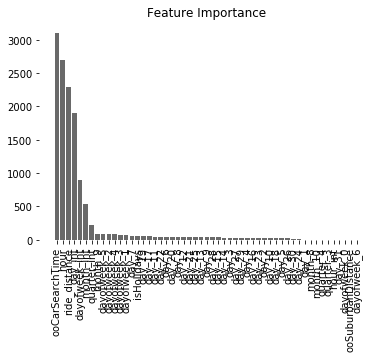

In [70]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Create plot
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(len(fNames)), feature_importances[indices], color = 'dimgray')

# Add feature names as x-axis labels
plt.xticks(range(len(fNames)), fNames[indices], rotation=90)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.show()

In [71]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(fNames, feature_importances):
    feats[feature] = importance #add the name/value pair 

# create DataFrame
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importances'})

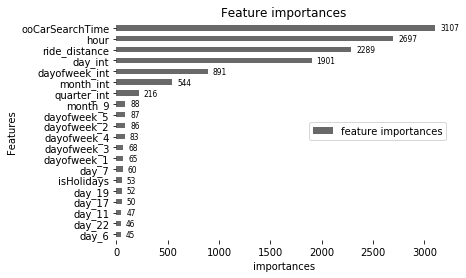

In [72]:
ax = importances.sort_values(by='feature importances').tail(20).plot(kind='barh', color = 'dimgray')

for p in ax.patches:
    ax.annotate(
        str(int(p.get_width())),
        (p.get_x() + p.get_width(), p.get_y()),
        xytext=(5,0),
        textcoords='offset points',
        horizontalalignment='left',
        fontsize=7.5
)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.title('Feature importances')
plt.xlabel('importances')
plt.ylabel('Features')
plt.legend(loc="center right")
plt.show()

### ExtraTreesRegressor

In [73]:
etr = ExtraTreesRegressor(random_state=1)

In [74]:
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

In [75]:
y_pred = etr.predict(X_test)

In [76]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 450.96


In [77]:
mean_absolute_percentage_error(y_test, y_pred)

12.281983154377036

### Stacking. Not actually good, not yet. but i leave there just for example

In [83]:
# Construct a Pipeline from the best estimators.
pipeline = make_pipeline(
    StackingEstimator(estimator=linear_model.LinearRegression()),
    StackingEstimator(estimator=RandomForestRegressor(n_estimators=100, random_state=1)),
    StackingEstimator(estimator=xgb.XGBRegressor(random_state=1)),
    lgb.LGBMRegressor(objective='mape',n_estimators=300, learning_rate=0.2, num_leaves=45)
)

In [84]:
# Fit the Pipeline on train subsets
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('stackingestimator-1', StackingEstimator(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))), ('stackingestimator-2', StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_le....0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [85]:
y_pred = pipeline.predict(X_test)

In [86]:
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))

Mean squared error: 429.32


In [87]:
# The mean absolute percentage error
print("Mean absolute percentage error: %.3f" % mean_absolute_percentage_error(y_test, y_pred) + '%')

Mean absolute percentage error: 11.755%
